## Obtener los datos

In [1]:
# Descarga de archivos de ProfNER
!wget -O profner.zip https://zenodo.org/record/4563995/files/profner.zip?download=1
# Si el unzip no funciona, revisar cual es el nombre de descarga del archivo
!unzip profner.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


Funciones de carga y preparación de datos

In [2]:
import sys
import os
import pandas as pd
def get_tweet_content(list_paths):
  """
    Función para guardar en un diccionario el contenido de archivos txt 
    que se introduce en su entrada. 
    Devuelve un diccionario en el que las claves son el id del tweet, y
    el valor el texto del tweet.
  """
  output_dict = dict()
  for i in list_paths:
    tweet_id = i.split("/")[-1].split(".txt")[0]
    with open(i) as f:
      output_dict[int(tweet_id)] = f.read()
  
  return output_dict

def get_profner_data(profner_path_data):
    # Obtenemos el path a los txt de los tweets.
    path_to_txt = profner_path_data+"subtask-1/train-valid-txt-files/"
    tweets_train_files = [path_to_txt+"train/"+i for i in os.listdir(path_to_txt+"train/")]
    tweets_valid_files = [path_to_txt+"valid/"+i for i in os.listdir(path_to_txt+"valid/")]
    # Obtenemos diccionarios en los que el key es el tweet_id y el value el texto del tweet.
    train_txt_content = get_tweet_content(tweets_train_files)
    valid_txt_content = get_tweet_content(tweets_valid_files)

    # Cargamos dos dataframes con los tweet_id y la categoría de los tweets
    path_to_labeled = profner_path_data+"subtask-1/"
    train_tweets = pd.read_csv(path_to_labeled+"train.tsv",sep="\t")
    valid_tweets = pd.read_csv(path_to_labeled+"valid.tsv",sep="\t")

    # Introducimos a los df el campo de texto mapeando los diccionarios con tweet_id
    train_tweets["tweet_text"] = train_tweets['tweet_id'].map(train_txt_content)
    train_tweets["set"] = "train"
    valid_tweets["tweet_text"] = valid_tweets['tweet_id'].map(valid_txt_content)
    valid_tweets["set"] = "valid"

    # Concatenamos el resultado
    output_df = pd.concat([train_tweets,valid_tweets],axis=0)
    # Eliminamos retorno de carro
    output_df["tweet_text"] = output_df.tweet_text.apply(lambda x: x.replace('\n', ' '))
    return output_df[["tweet_id","tweet_text","label","set"]].reset_index(drop=True)

# Descripcion del Problema

En este ejercicio se trabajará con un conjunto de datos reales publicados para la shared-task [ProfNER](https://temu.bsc.es/smm4h-spanish/), celebrada en el año 2021. Este conjunto de datos son tweets en español que tienen asignada una etiqueta numérica, que representa la presencia (valor 1) o no (valor 0) de menciones de profesiones en el tweet. Para mayor referencia, el proceso de obtención, selección y anotación de datos está descrita en [este enlace.](https://temu.bsc.es/smm4h-spanish/?p=4003).

## Librerias


In [3]:
import nltk
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import string
import re
#import contractions
from tqdm.autonotebook import tqdm
tqdm.pandas()


<ipython-input-3-24c8ffeee430>:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
nltk.download('popular')
nltk.download('nltk_data')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

True

## Obtención del corpus
Para la obtención de los datos teneis se utiliza la función `get_profner_data()`. Esta función prepara los datos del ejercicio en formato Pandas dataframe.

In [5]:
profner_path = "./profner/"
datos_ejercicio = get_profner_data(profner_path)

In [6]:
datos_ejercicio.head(4)

,tweet_id,tweet_text,label,set
0,1256007275807997953,CHINA: libera una pandemia EE.UU: libera OVNIS...,0,train
1,1257909427677601792,San Francisco (EEUU) hace 100 años tras vivir ...,0,train
2,1281580572415066112,Porfi poneos la mascarilla o tendremos 28 nuev...,0,train
3,1271348112733470720,El nuevo „covid normas y reglas recibimiento“ ...,0,train


In [7]:
def visualizar_k_rows (df, num_filas, cmap):
  return (df.head(num_filas).style.background_gradient(cmap=cmap))

In [8]:
visualizar_k_rows(datos_ejercicio.sample(50), 10, 'RdBu_r')

,tweet_id,tweet_text,label,set
1343,1247124536077824000,Les estudiantes exigen garantías ante la situación actual y medidas para evitar que la brecha socioeconómica existente se haga más pronunciada. Todo nuestro apoyo a estas reivindicaciones de las que os iremos informando ✊ #Covid_19 #Estudiantes #EstadoDeAlarma @AbrirBrecha https://t.co/dEVfJ9D9YC,1,train
1114,1256483023152992256,"Los bulos ultras. El titular debería ser “La GC es cazada saltándose la normativa” ➡️Ir dl trabajo a casa no es saltarse el confinamiento. ➡️Retener a un diputado, intentar sancionarle sin motivo y no dar copia d la denuncia es un comportamiento irregular y arbitrario. https://t.co/p3w1Pm87jK",1,train
7635,1261958095502221312,"En un acto de graduación, el expresidente norteamericano Barack Obama ha criticado la gestión de la pandemia realizada por el gobierno de Donald Trump https://t.co/C64heNKti8",1,valid
2600,1291713859569553408,Las 10 monjas de clausura del Convento de las Brígidas de Lasarte-Oria (Guipúzcoa) han dado positivo por coronavirus,1,train
1037,1256018193858138112,"#RecortaronYRobaron Este Frente tiene claro que la unidad de la Izquierda es el camino, los procesos basados en el protagonismo y en la participación de la ciudadanía, no sólo suman, si no que multiplican #SumarEsMultiplicar Únete al @FrenteDeIzdas #YoMeQuedoEnCasa https://t.co/vZi7vi2MTn",0,train
3615,1258062577395007488,"Cuando viajes, conecta con las gentes del lugar, siempre saldrás ganando en el #DestinoGeoparqueVilluercasIboresJara porque #AquíEstarasMejorQueEnBrazos #YoMeQuedoEnCasa #stopcoronavirus #ecoturismo #slowtravel #turismoslow @Extremadura_tur @VilluercasGPark https://t.co/oCu0zfKFiD",0,train
3517,1271066224454242304,"Bien por @consumogob, que ha actuado con rapidez ante la proliferación de la ilegal 'tasa Covid'. Ahora toca que las autoridades de consumo autonómicas impongan multas a los establecimientos que continúen cobrando estos recargos. https://t.co/gha49xYYN8",0,train
4089,1263879411046236160,@JordiWild Se que son dos letras pero Bon Covid jajaja,0,train
1034,1258828155588091904,"Título de la película: ""El hombre que susurraba a las ovejas mientras hacía campaña electoral diaria en plena pandemia y sin hacer ni una sola propuesta en el congreso."" https://t.co/UkKR2GoCnB",0,train
6923,1285532305239531520,🚨Lleida atiende hasta a 600 sospechosos de covid al día en los ambulatorios https://t.co/E4hBFRakXV,0,valid


## Análisis exploratorio

In [9]:
print(f'El dataset de estudio contiene una cantidad de {datos_ejercicio.shape[0]} tweets')
print(f'Este a su vez contiene un numero de {datos_ejercicio.shape[1]} columnas')

El dataset de estudio contiene una cantidad de 8000 tweets
Este a su vez contiene un numero de 4 columnas


In [10]:
datos_ejercicio[datos_ejercicio.set != 'train'].shape[0]

2000

In [11]:
datos_ejercicio.set.value_counts()

train    6000
valid    2000
Name: set, dtype: int64

In [12]:
print('datos entrenamiento')
display(datos_ejercicio[datos_ejercicio.set == 'train'].label.value_counts(normalize=True))
print()
print('datos prueba')
display(datos_ejercicio[datos_ejercicio.set != 'train'].label.value_counts(normalize=True))

datos entrenamiento


0    0.767833
1    0.232167
Name: label, dtype: float64


datos prueba


0    0.7615
1    0.2385
Name: label, dtype: float64

El dataset contiene una columna llamada set, con dos clases distintas que son train y valid con ocurrencias de 6000 y 2000 registros respectivamente y al comparar la distribución de las categorías de la variable label, se mantiene el porcentaje de ocurrencias de cada una, señal de que ya está dividido el conjunto de datos en training y test desde un inicio.

In [13]:
print(f'Validando si existen registros duplicados, nos encontramos con que hay {np.sum(datos_ejercicio.duplicated(subset="tweet_text"))} tweets repetidos')

Validando si existen registros duplicados, nos encontramos con que hay 0 tweets repetidos


In [14]:
print(f'En el caso de valores nulos, el dataset contiene {np.sum(datos_ejercicio.isnull())[1]} faltantes en la columna de texto y {np.sum(datos_ejercicio.isnull())[2]} faltantes en la columna de etiqueta')

En el caso de valores nulos, el dataset contiene 0 faltantes en la columna de texto y 0 faltantes en la columna de etiqueta


In [15]:
datos_ejercicio.label.value_counts(normalize=True)

0    0.76625
1    0.23375
Name: label, dtype: float64

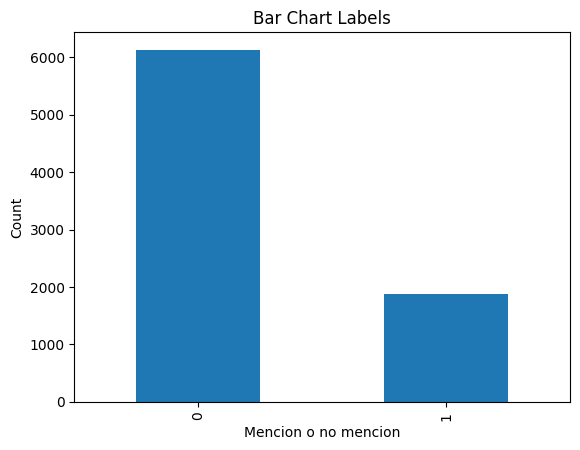

In [16]:
ax, fig = plt.subplots()
etiquetas = datos_ejercicio.label.value_counts()
etiquetas.plot(kind='bar')
plt.title('Bar Chart Labels')
plt.xlabel('Mencion o no mencion')
plt.ylabel('Count')
plt.show();

Vemos que la variable objetivo esta desbalanceada, lo que podría suponer un problema más delante al entrenar el modelo.

In [17]:
datos_ejercicio['tweets_len'] = datos_ejercicio['tweet_text'].apply(lambda x: len(x))

<Figure size 1200x1000 with 0 Axes>

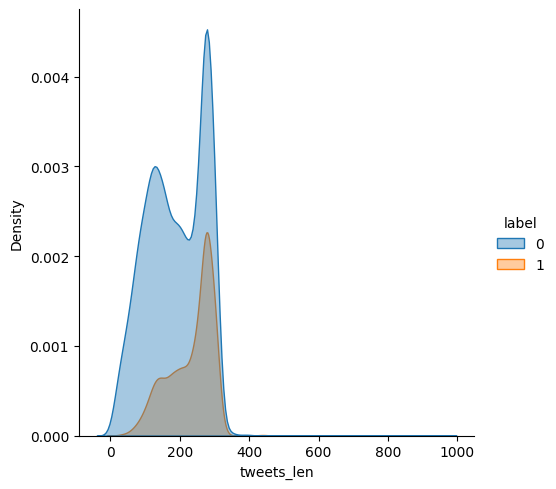

In [18]:
fig = plt.figure(figsize=(12,10))
plt1 = sns.displot(datos_ejercicio, x="tweets_len", hue='label', kind="kde",fill=True, common_norm=True,alpha=0.4)

plt.show();

In [19]:
print('si se toma en cuenta un valor maximo de 35 caracteres por tweets, se puede observar la gran ocurrencia de etiquetas iguales a 0 sobre el total:')
print('Numero de tweets sin menciones con un maximo de 35 caracteres:')
display(datos_ejercicio[(datos_ejercicio.tweets_len < 35)&(datos_ejercicio.label == 0) ].shape[0])
print('Numero total de tweets con un maximo de 35 caracteres')
display(datos_ejercicio[(datos_ejercicio.tweets_len < 35) ].shape[0])


si se toma en cuenta un valor maximo de 35 caracteres por tweets, se puede observar la gran ocurrencia de etiquetas iguales a 0 sobre el total:
Numero de tweets sin menciones con un maximo de 35 caracteres:


145

Numero total de tweets con un maximo de 35 caracteres


146

Llegando a un numero de caracteres (sin limpiar) como puede ser por ejemplo 35, no se suele apreciar menciones a profesiones, y seguramente se traten de mensajes con muchos caracteres especiales, menciones o páginas web.

En conclusión, las distribuciones de las longitudes en los tweets para el caso en el que no haya menciones a profesiones es similar, a cuando si hay menciones, y no se pueden separar viendo únicamente sus distribuciones, ya que una se encuentra dentro de la silueta de la otra, por lo que se debería entrenar bien un modelo para clasificar estas dos. No obstante, cabe recalcar que cuando la cantidad de caracteres es muy pequeña, no suelen haber menciones a profesiones.

## Preprocesado y Normalización

**Material y tratamiento de emoticonos en los tweets**

Para el analisis de sentimiento, se descargan los siguientes recursos facilitados en el foro de clase.

In [20]:
# Download emoji sentiment
!wget https://www.clarin.si/repository/xmlui/handle/11356/1048/allzip
!unzip allzip

--2023-05-14 23:47:46--  https://www.clarin.si/repository/xmlui/handle/11356/1048/allzip
Resolving www.clarin.si (www.clarin.si)... 95.87.154.205
Connecting to www.clarin.si (www.clarin.si)|95.87.154.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘allzip’

allzip                  [        <=>         ]  94.61K  42.8KB/s    in 2.2s    

2023-05-14 23:47:50 (42.8 KB/s) - ‘allzip’ saved [96878]

Archive:  allzip
  inflating: ESR_v1.0_format.txt     
  inflating: Emoji_Sentiment_Data_v1.0.csv  
  inflating: Emojitracker_20150604.csv  


In [21]:
# Preparar diccionario de emojis
def load_emoji_sentiment(path):
  # Cargamos el csv de emoji_sentiment
  emoji_sent_df = pd.read_csv(path,sep=",")
  # Calculamos los scores dividiendo el número de emojis negativos y entre el total
  emoji_sent_df["Negative"] = emoji_sent_df["Negative"]/emoji_sent_df["Occurrences"]
  emoji_sent_df["Neutral"] = emoji_sent_df["Neutral"]/emoji_sent_df["Occurrences"]
  emoji_sent_df["Positive"] = emoji_sent_df["Positive"]/emoji_sent_df["Occurrences"]
  # Transformamos a dict
  emoji_sent_df = emoji_sent_df.set_index('Emoji')
  emoji_dict = emoji_sent_df.to_dict(orient="index")
  return emoji_dict

In [22]:
!pip install emoji_extractor
!pip install emoji
from emoji_extractor.extract import Extractor
# Función para extraer emojis del texto en formato lista
def extract_emojis(text):
  extract = Extractor()
  emojis = extract.count_emoji(text, check_first=False)
  emojis_list = [key for key, _ in emojis.most_common()]
  return emojis_list

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for emoji_extractor: filename=emoji_extractor-2.0.0-py3-none-any.whl size=64157 sha256=41e1810eb3561fd4abe6961e021bb523016459fba9e3f0663089c261346e958d
  Stored in directory: /root/.cache/pip/wheels/14/89/95/33d1b161e1daa8fb2dec089e887d3620d3a318fdb0798e9f58
Successfully built emoji_extractor
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 kB 20.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234911 sha256=18d9c045b513c1aea522f89e0663638fa54062d2f1ac98a72ea6411507b0099e
  Stored in directory: /root/.cache/pip/wheels/02/3d/88/51a592b9ad17e7899126563698b4e3961983ebe85747228ba6
Successfully built emoji


In [23]:
def get_emoji_sentiment(lista, option = "positive"):
  output = 0
  for emoji in lista:
    try:
      if option == "positive":
        output = output + emoji_sent_dict[emoji]["Positive"]
      elif option =="negative":
        output = output + emoji_sent_dict[emoji]["Negative"]
      elif option =="neutral":
        output = output + emoji_sent_dict[emoji]["Neutral"]
    except Exception as e: 
      continue
  return output

In [24]:
emoji_sent_dict = load_emoji_sentiment("Emoji_Sentiment_Data_v1.0.csv")
#emoji_sent_dict

In [25]:
datos_ejercicio["emoji_list"] = datos_ejercicio["tweet_text"].apply(lambda x: extract_emojis(x))

In [26]:
#datos_ejercicio.emoji_list
datos_ejercicio["sent_emoji_pos"] = datos_ejercicio["emoji_list"].apply(lambda x: get_emoji_sentiment(x, "positive"))
datos_ejercicio["sent_emoji_neu"] = datos_ejercicio["emoji_list"].apply(lambda x: get_emoji_sentiment(x, "neutral"))
datos_ejercicio["sent_emoji_neg"] = datos_ejercicio["emoji_list"].apply(lambda x: get_emoji_sentiment(x, "negative"))

Se crean las 3 nuevas variables para expresar los índices de sentimiento que refleja cada emoji (algunos no están incluidos en esta lista por lo que tomaran valores de 0).

**Recursos y funciones para el preprocesado de tweets**

In [27]:
!python -m spacy download es_core_news_sm
!pip install spanlp

2023-05-14 23:48:30.624763: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-14 23:48:32.622889: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 63.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 4.4 MB/s eta 0:00:00


In [28]:
from nltk import word_tokenize
from nltk.corpus import stopwords
import spacy

#Recursos en espanol
from spanlp.domain.strategies import Preprocessing, RemoveConjunctions, RemoveAdverbs


#el parser y ner se utilizan como componentes de análisis de sintaxis y reconocimiento de entidades nombradas (NER)
#deshabilitarlos ayuda a que corra mas rapido el codigo
#se carga en espanol el archivo de spacy.
nlp = spacy.load('es_core_news_sm', disable=['parser', 'ner'])

# Eliminar menciones y URLS
def limpiar_tweets(text):
  #menciones
  #text = re.sub(r'@\w+', '', text)
  # Eliminar URLs
  text = re.sub(r'http\S+', 'url', text)
  return text

def eliminar_espacios(text):
  return " ".join(text.split())

def texto_to_lower(text):
  return text.lower()

def replace_contractions(text): #En espanol no es necesario, omitir este paso
  expanded_words = [contractions.fix(text) for text in text.split()]
  expanded_text = ' '.join(expanded_words)
  return expanded_text

def tokenization(text): #ver libreria spanlp, tener en cuenta el tokenizador.
  #ingles
  #tokens = word_tokenize(text)
  #se aprovecha para eliminar adverbios y conjuciones que no deberian ser de utilidad para que el modelo clasifique textos.
  strategies = [RemoveConjunctions(), RemoveAdverbs()]
  cleaned = Preprocessing().clean(data=text, clean_strategies=strategies)
  doc = nlp(text)

  tokens = [token.text for token in doc]

  return tokens

def no_stopwords(tokens):
  stop_words = set(stopwords.words('spanish'))
  filtered_sentence = [word for word in tokens if not word in stop_words]
  return filtered_sentence
# en este caso se quitaran numeros tambien, ya que no tienen relevancia
def quitar_puntuaciones(tokens):
  words = [word for word in tokens if word.isalpha()]
  return words

def lematizar(tokens):
  sentence = ' '.join(tokens)
  mytokens = nlp(sentence)
  mytokens = [word.lemma_ if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens]
  return mytokens

from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('spanish')
def stem(tokens):
  tokens = [stemmer.stem(tokens) for token in tokens]
  return tokens
  


In [29]:
# Eliminar los emojis de un texto. Esto es útil porque una vez extraido los emojis
# puede interesarnos tener un texto sin presencia de emojis para mejor análisis.
def clean_emoji(text):
    # Poner todos los comandos de http://www.unicode.org/Public/emoji/1.0/emoji-data.txt
    emoji_pattern = re.compile("["
        u"\U0001F300-\U0001F6FF"  # symbols & pictographs
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u'\u2600-\u26FF\u2700-\u27BF'
        u'\u2934' u'\u2935' u'\u2B05' u'\u2B06' u'\u2B07' u'\u2B1B' u'\u2B1C' 
        u'\u2B50' u'\u2B55' u'\u3030' u'\u303D' u'\u3297' u'\u3299' u'\u00A9'
        u'\u00AE' u'\u203C' u'\u2049' u'\u2122' u'\u2139' u'\u2194-\u2199' 
        u'\u21A9' u'\u21AA' u'\u231A' u'\u231B' u'\u2328' u'\u23CF'
        u'\u23E9-\u23F3' u'\u23F8' u'\u23F9' u'\u23FA' u'\u24C2' u'\u25AA'
        u'\u25AB' u'\u25B6' u'\u25C0' u'\u25FB' u'\u25FD' u'\u25FC' u'\u25FE'
        ']+', flags=re.UNICODE)
    string2 = re.sub(emoji_pattern,r' ',text)
    return string2

Considerando que los datos provienen de una red social como lo es twitter, y que al explorar los datos se observan ocurrencias de enlaces web, se incluye un paso inicial para eliminar dichas páginas web para posteriormente aplicar el preprocesado del texto visto en clase, juntando todas las funciones brindadas en una sola.

In [30]:
#Juntando las funciones en una sola:
def procesar_texto(text, tokenizar=True, normalizar='stem'):
    #reemplazar URLs
    text = limpiar_tweets(text)
    #Eliminar emojis
    text = clean_emoji(text)
    # eliminar espacios
    text = eliminar_espacios(text)
    # convertir texto a minúsculas
    text2 = texto_to_lower(text)
    # expandir contracciones
    #text3 = replace_contractions(text2)
    # tokenizar
    if tokenizar:
        tokens = tokenization(text2)

    # eliminar stopwords
    tokens = no_stopwords(tokens)
    # quitar puntuaciones
    tokens = quitar_puntuaciones(tokens)
    # normalizar
    if normalizar == 'lematizar':
        tokens = lematizar(tokens)
    elif normalizar == 'stem':
        tokens = stem(tokens)
    else:
        raise ValueError('Valor no válido para el argumento "normalizar".')
    return tokens

**Recursos para el analisis de sentimiento de los tokens preprocesados**

In [31]:
url_path = "https://www.cic.ipn.mx/~sidorov/SEL.txt"
sel_lexicon = pd.read_csv(url_path,sep="\t", encoding="latin-1")

In [32]:
dicc_mapping = {"Alegría":"positive",
                "Sorpresa":"positive",
                "Tristeza":"negative",
                "Enojo":"negative",
                "Miedo":"negative",
                "Repulsión":"negative"}
                
sel_lexicon["Categoría"] = sel_lexicon["Categoría"].map(dicc_mapping)

In [33]:
positive_words = dict(zip(sel_lexicon[sel_lexicon["Categoría"]=="positive"].Palabra, sel_lexicon[sel_lexicon["Categoría"]=="positive"][' PFA']))
negative_words = dict(zip(sel_lexicon[sel_lexicon["Categoría"]=="negative"].Palabra, sel_lexicon[sel_lexicon["Categoría"]=="negative"][' PFA']))

def calculate_sentiment(frase, positive_words, negative_words):
  """
  Función para calcular el score de sentimiento de una frase

  Args:
    frase [str]: Frase pre-preprocesada en español. Debe venir lematizada.
    positive_words [dict]: Diccionario de palabras positivas extraidas de SEL
    negative_words [dict]: Diccionario de palabras negativas extraídas de SEL

  Out:
    Sentiment score  
  """
  score = 0
  for i in frase.split():
    if i in positive_words:
      score = score + float(positive_words[i])
    elif i in negative_words:
      score = score - float(negative_words[i])
    else:
      score = score + 0
  
  return score

**Aplicacion del preprocesado de texto**

In [34]:
datos_ejercicio['normalizado'] = datos_ejercicio['tweet_text'].progress_apply(lambda x : procesar_texto(x, tokenizar=True, normalizar='lematizar'))

  0%|          | 0/8000 [00:00<?, ?it/s]

In [35]:
datos_ejercicio['normalizado']

0       [chino, libera, pandemia, libera, ovnis, argen...
1       [san, francisco, eeuu, hacer, año, tras, vivir...
2       [porfi, poneo, mascarilla, nuevo, canción, art...
3       [nuevo, covid, norma, regla, recibimiento, com...
4       [si, confinamiento, dejado, tocado, estabilida...
                              ...                        
7995    [lomásleer, nuevo, infectado, coronavirus, mul...
7996    [ayuso, adjudico, dedo, contrato, euros, hacer...
7997    [mes, encerrado, poder, viajar, provincia, ir,...
7998    [gobierno, prohíbir, ley, lis, despido, crisis...
7999         [rasgo, psicológico, lleva, mascarilla, url]
Name: normalizado, Length: 8000, dtype: object

In [36]:
datos_ejercicio['clean_tweets'] = datos_ejercicio['normalizado'].progress_apply(lambda x: " ".join(x))
datos_ejercicio.clean_tweets

  0%|          | 0/8000 [00:00<?, ?it/s]

0       chino libera pandemia libera ovnis argentino l...
1       san francisco eeuu hacer año tras vivir pandem...
2       porfi poneo mascarilla nuevo canción artista c...
3       nuevo covid norma regla recibimiento comercio ...
4       si confinamiento dejado tocado estabilidad men...
                              ...                        
7995    lomásleer nuevo infectado coronavirus multipli...
7996    ayuso adjudico dedo contrato euros hacer vídeo...
7997    mes encerrado poder viajar provincia ir restau...
7998    gobierno prohíbir ley lis despido crisis coron...
7999               rasgo psicológico lleva mascarilla url
Name: clean_tweets, Length: 8000, dtype: object

In [37]:
datos_ejercicio.sample(5)

,tweet_id,tweet_text,label,set,tweets_len,emoji_list,sent_emoji_pos,sent_emoji_neu,sent_emoji_neg,normalizado,clean_tweets
2531,1269154307066277895,La Guardia Civil pidió sin orden judicial a un...,1,train,192,[],0.0,0.0,0.0,"[guardia, civil, pedir, orden, judicial, super...",guardia civil pedir orden judicial supermercad...
3991,1254754135062327298,🇨🇳🇦🇺 | URGENTE - #CORONAVIRUS: China amenaza a...,0,train,141,"[🇨🇳, 🇦🇺]",0.0,0.0,0.0,"[urgente, coronavirus, china, amenaza, austral...",urgente coronavirus china amenaza australia to...
1156,1270038821162364938,#coronavirus #COVIDー19 #CoronavirusEnEcuador #...,0,train,300,[],0.0,0.0,0.0,"[coronaviru, coronavirusenecuador, coronavirus...",coronaviru coronavirusenecuador coronavirusenu...
1782,1255185180240883713,"@TxabyJJ A 1,10 eché yo hoy en Repsol de la co...",0,train,142,[],0.0,0.0,0.0,"[eché, hoy, repsol, corredorio, x, mañana, apr...",eché hoy repsol corredorio x mañana aprovechar...
4630,1266482693082165250,¿POR QUÉ NO LO HACEN? Tan sólo 3 millones de...,1,train,290,[],0.0,0.0,0.0,"[hacer, tanto, sólo, millón, euros, costar, co...",hacer tanto sólo millón euros costar contratar...


Ahora que se encuentra limpio el texto, se procede a extraer el sentimiento de este.

**Extraer sentimiento del texto preprocesado**

In [38]:
datos_ejercicio["sent_frase_score"] = datos_ejercicio["clean_tweets"].apply(lambda x: calculate_sentiment(x, positive_words, negative_words))

In [39]:
datos_ejercicio["sent_frase_score"].describe()

count    8000.000000
mean       -0.005651
std         0.645833
min        -3.982000
25%        -0.205000
50%         0.000000
75%         0.231000
max         4.191000
Name: sent_frase_score, dtype: float64

Text(0.5, 1.0, 'Histograma Sentimiento tweets preprocesados')

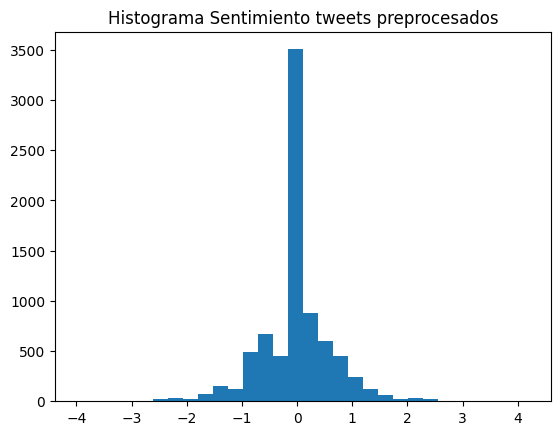

In [40]:
 plt.hist(datos_ejercicio["sent_frase_score"], bins=30)
 plt.title('Histograma Sentimiento tweets preprocesados')

Predominan mucho los 0, lo que quiere decir que en cuanto a sentimiento, se prevee que es neutro para la mayoria de los tweets.

In [41]:
datos_ejercicio['tokens_len'] = datos_ejercicio['normalizado'].progress_apply(lambda x: len(x))

  0%|          | 0/8000 [00:00<?, ?it/s]

<Figure size 1200x1000 with 0 Axes>

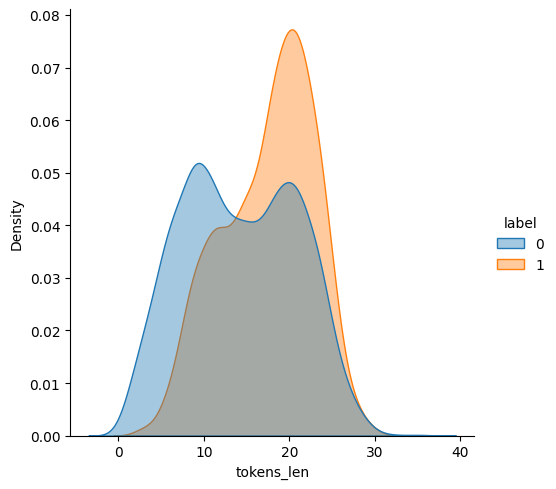

In [42]:
fig = plt.figure(figsize=(12,10))
plt1 = sns.displot(datos_ejercicio, x="tokens_len", hue='label', kind="kde",fill=True, common_norm=False,alpha=0.4)

plt.show();

Las distribuciones de las cantidades de tokens en las categorías con y sin mención de profesiones posee un comportamiento similar a la inicial sin el preprocesado de texto, se ve una reducción considerable de la cantidad de elementos (tokens) y se continua observando como a menor cantidad de tokens es más probable que no haya mención a profesiones (categoría "0").

## Vectorización

In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizador = TfidfVectorizer(ngram_range=(1,3),
                               min_df=0.001,
                               lowercase=False)

Se tomara en cuenta un valor en el argumento min_df de 0.005, dependiendo de los resultados que de el futuro modelo se revisara si hay o no que modificar este valor limite.

In [74]:
tfidf_data = vectorizador.fit(datos_ejercicio['clean_tweets'])

In [75]:
tfidf_data.get_feature_names_out()

array(['abajo', 'abandonado', 'abandonar', ..., 'último semana', 'único',
       'útil'], dtype=object)

In [76]:
len(list(tfidf_data.get_feature_names_out()))

2711

Se nota la presencia de muchos valores numéricos dentro del vocabulario generado, lo cual no sirve de mucho para este caso de clasificación de texto y no existe relevancia entre números y profesiones para este contexto de evaluar si existe o no una mención a profesiones)



In [77]:
vector_data = tfidf_data.transform(datos_ejercicio['clean_tweets']).toarray()

In [78]:
extra_features = datos_ejercicio[['sent_emoji_pos','sent_emoji_neg','sent_emoji_neu','sent_frase_score', 'tokens_len']]
type(vector_data)

numpy.ndarray

In [79]:
X = np.column_stack([vector_data, extra_features])
vector_data.shape, extra_features.shape, X.shape

((8000, 2711), (8000, 5), (8000, 2716))

In [80]:
y = datos_ejercicio["label"].values.astype(np.float32) 

## Entrenamiento y evaluación de modelos


In [82]:
# Comprobamos dimensiones
print('Training dataset shape:', X_train.shape, y_train.shape)

Training dataset shape: (6000, 2716) (6000,)


In [83]:
from sklearn.model_selection import (KFold, cross_val_score, GridSearchCV, RandomizedSearchCV)
import warnings

def model_evaluation(models, score, X, y):
  results = []
  names = []

  for name, model in models:
    warnings.filterwarnings('ignore')

    KF = KFold(n_splits = 10, shuffle =True, random_state = 23)

    cv_results = cross_val_score(model, X, y, cv = KF, scoring = score, verbose = False)

    results.append(cv_results)
    names.append(name)

    print(f'Metric: {str(score)} , KFold')
    print("%s: %f (%f) " % (name, cv_results.mean(), cv_results.std()))

  return results, names

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

models = [('Logistic', LogisticRegression(random_state=30)),
          ('GaussianNB', GaussianNB()),
          ('DecissionTree', DecisionTreeClassifier()),
          ('SMV', LinearSVC(class_weight = 'balanced' )),
          ('Random Forest', RandomForestClassifier(random_state=42))]

evaluation_score = "f1"

model_evaluation(models, evaluation_score, X_train, y_train)

Metric: f1 , KFold
Logistic: 0.481866 (0.045322) 
Metric: f1 , KFold
GaussianNB: 0.395602 (0.030139) 
Metric: f1 , KFold
DecissionTree: 0.640434 (0.037475) 
Metric: f1 , KFold
SMV: 0.652939 (0.042305) 


Probando con 5 tipos de clasificadores distintos, el que mejor valor de f1 da por diferencia es el Random Forest, por lo que se procederá a observar las demas metricas de precision para tener una idea del comportamiento del modelo.

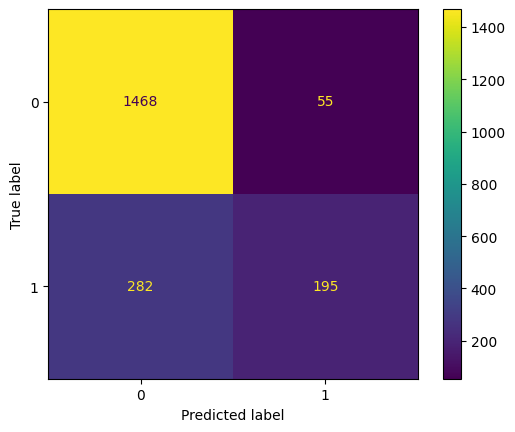

In [55]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

modelo_ganador = RandomForestClassifier(random_state=42)
modelo_ganador.fit(X_train, y_train)
y_pred = modelo_ganador.predict(X_test)
y_pred_rounded = np.round(y_pred, decimals=0)
cm = confusion_matrix(y_test, y_pred_rounded)

cm_display = ConfusionMatrixDisplay(cm).plot()
cm_display


In [56]:
from sklearn import metrics
from sklearn.metrics import classification_report
print(metrics.classification_report(y_pred_rounded, y_test))

              precision    recall  f1-score   support

         0.0       0.96      0.84      0.90      1750
         1.0       0.41      0.78      0.54       250

    accuracy                           0.83      2000
   macro avg       0.69      0.81      0.72      2000
weighted avg       0.89      0.83      0.85      2000



El modelo es capaz de predecir satisfactoriamente los casos en los que no hay mención a profesiones (valores de 0 ), sin embargo, a la hora de predecir los casos en los que si hay mención a profesión el modelo no es capaz de predecir con la misma precisión los valores verdaderos de esta clase. Esto pasa debido a lo que se ha estado comentando desde un inicio, que la variable objetivo esta desbalanceada y el modelo requiere de un mayor numero de casos positivos para que pueda distinguir con mayor eficiencia estos.

Se intentará balancear esta clase para contrastar si se obtienen mejores resultados de precisión.

In [57]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Realiza la validación cruzada
scores = cross_val_score(modelo_ganador, X_train, y_train, cv=cv, n_jobs=-1)

# Evalúa el rendimiento del modelo
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.845 (0.007)


**Balanceo de la variable objetivo**

In [58]:
from imblearn.over_sampling import SMOTE
# Creamos objeto SMOTE
#sampling_strategy = {1: 6130, 0:6130}
sm = SMOTE(random_state=25)
# Aplicamos objeto SMOTE 
X_smote, y_smote = sm.fit_resample(X_train, y_train)

In [59]:
print('After OverSampling, the shape of train_X: {}'.format(X_train.shape))
print('After OverSampling, the shape of train_y: {}'.format(y_train.shape))

print("Before OverSampling, counts of label '1': {}".format(sum(datos_ejercicio.label==1)))
print("Before OverSampling, counts of label '0': {}".format(sum(datos_ejercicio.label==0)))



print('After OverSampling, the shape of train_X: {}'.format(X_smote.shape))
print('After OverSampling, the shape of train_y: {}'.format(y_smote.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_smote==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_smote==0)))

After OverSampling, the shape of train_X: (6000, 486)
After OverSampling, the shape of train_y: (6000,)
Before OverSampling, counts of label '1': 1870
Before OverSampling, counts of label '0': 6130
After OverSampling, the shape of train_X: (9214, 486)
After OverSampling, the shape of train_y: (9214,)
After OverSampling, counts of label '1': 4607
After OverSampling, counts of label '0': 4607


In [60]:
model_evaluation(models, evaluation_score, X_smote, y_smote)

Metric: f1 , KFold
Logistic: 0.778546 (0.016074) 
Metric: f1 , KFold
GaussianNB: 0.751701 (0.016661) 
Metric: f1 , KFold
DecissionTree: 0.836991 (0.013193) 
Metric: f1 , KFold
SMV: 0.782797 (0.023193) 
Metric: f1 , KFold
Random Forest: 0.900164 (0.010338) 


([array([0.78611422, 0.77434135, 0.77483444, 0.78290214, 0.75963719,
         0.77375566, 0.81497797, 0.75175644, 0.78329571, 0.78384279]),
  array([0.76623377, 0.73532669, 0.75757576, 0.75687104, 0.74433657,
         0.73456121, 0.78518519, 0.72489083, 0.7537797 , 0.75825346]),
  array([0.83905579, 0.83552632, 0.83696781, 0.84582441, 0.84473398,
         0.81767956, 0.86554622, 0.81737194, 0.8336933 , 0.83351007]),
  array([0.80174292, 0.76779463, 0.79443255, 0.79510022, 0.7688734 ,
         0.7323601 , 0.82154171, 0.78280543, 0.77010193, 0.79321315]),
  array([0.90033595, 0.89906103, 0.90849673, 0.89491525, 0.91240046,
         0.8960739 , 0.92087912, 0.88604651, 0.89576174, 0.8876652 ])],
 ['Logistic', 'GaussianNB', 'DecissionTree', 'SMV', 'Random Forest'])

Al balancear las categorías en el conjunto de prueba utilizando el método Over Samppling, se observa que ahora el modelo que mejor resultados obtiene sigue siendo el Random Forest, mejorando considerablemente el f1 score del modelo ganador cuando las categorías de la variable objetivo no estaban balanceadas.

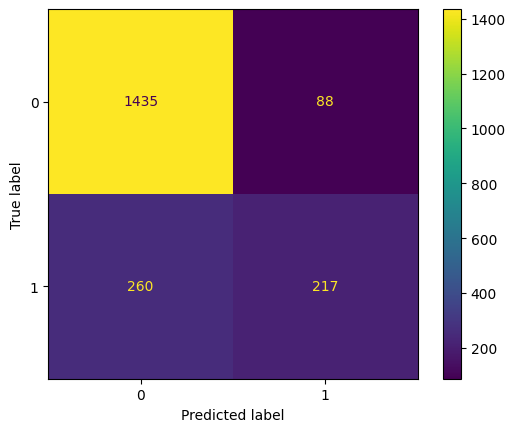

In [61]:
modelo_ranFor = RandomForestClassifier(random_state=35)
modelo_ranFor.fit(X_smote, y_smote)
y_pred_sm = modelo_ranFor.predict(X_test)
y_pred_rounded_sm = np.round(y_pred_sm, decimals=0)
cm = confusion_matrix(y_test, y_pred_rounded_sm)

cm_display = ConfusionMatrixDisplay(cm).plot()
cm_display


In [62]:
print(metrics.classification_report(y_pred_rounded_sm, y_test))

              precision    recall  f1-score   support

         0.0       0.94      0.85      0.89      1695
         1.0       0.45      0.71      0.55       305

    accuracy                           0.83      2000
   macro avg       0.70      0.78      0.72      2000
weighted avg       0.87      0.83      0.84      2000



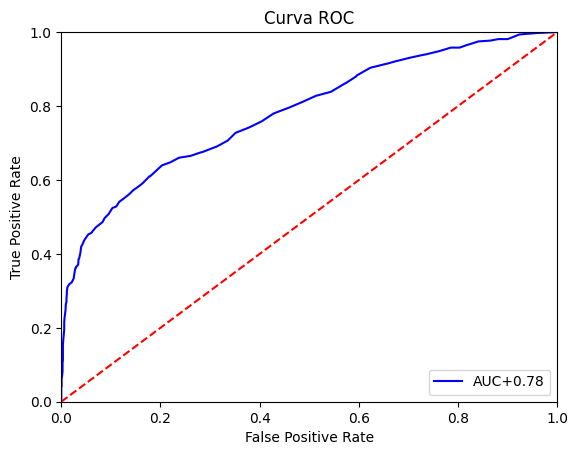

In [63]:
predicciones = modelo_ranFor.predict_proba(X_test)
pred = predicciones[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Curva ROC')
plt.plot(fpr, tpr, 'b', label= 'AUC+%0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

In [64]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Realiza la validación cruzada
scores = cross_val_score(modelo_ranFor, X_smote, y_smote, cv=cv, n_jobs=-1)

# Evalúa el rendimiento del modelo
print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Accuracy: 0.902 (0.005)


Se observa que los resultados en efecto mejoran al balancear las clases, pero esto a nivel de entrenamiento, ya que, al probar nuevamente los resultados con el conjunto de test, los resultados son un pelo mejor, especificamente 0,01 puntos emjor en cuanto a la metrica de f1, señal de que el modelo podria estar sobre ajustado. Es posible que con otros valores de prueba se obtengan mejores resultados, pero con los que se cuentan no se tuvo esta suerte.

In [65]:
from sklearn.model_selection import GridSearchCV
grid_param = {
    'n_estimators': [30, 50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False],
    'max_depth': [20,22,24]
}

modelo_ranFor_tuned = RandomForestClassifier().fit(X_smote, y_smote)
model_grid_smoted = GridSearchCV(estimator=modelo_ranFor_tuned,
                     param_grid=grid_param,
                     scoring='f1',
                     cv=5,
                     n_jobs=-1)

In [66]:
model_grid_smoted.fit(X_smote, y_smote)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [20, 22, 24],
                         'n_estimators': [30, 50, 100, 200]},
             scoring='f1')

In [67]:
print(model_grid_smoted.best_params_)

{'bootstrap': False, 'criterion': 'gini', 'max_depth': 24, 'n_estimators': 50}


In [68]:
print(model_grid_smoted.best_score_)

0.8616109626343249



Obteniendo los mejores hiperparametros para el modelo que mejor resultados arroja tras hacer las distintas validaciones, se vuelven a probar los valores predictivos del nuevo modelo tuneado.

Modelo Random Forest Tuneado.

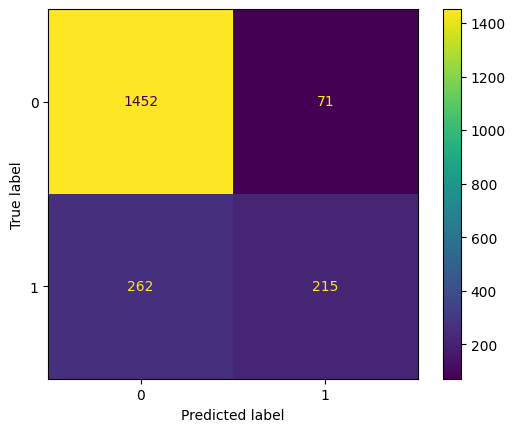

In [69]:
modelo_ran_tuned = RandomForestClassifier(bootstrap = False, criterion= 'gini', max_depth= 24, n_estimators= 50).fit(X_smote, y_smote)
y_pred_tuned = modelo_ran_tuned.predict(X_test)
y_pred_rounded_tuned = np.round(y_pred_tuned, decimals=0)
cm = confusion_matrix(y_test, y_pred_rounded_tuned)

cm_display = ConfusionMatrixDisplay(cm).plot()
cm_display

In [70]:
print(metrics.classification_report(y_pred_rounded_tuned, y_test))

              precision    recall  f1-score   support

         0.0       0.95      0.85      0.90      1714
         1.0       0.45      0.75      0.56       286

    accuracy                           0.83      2000
   macro avg       0.70      0.80      0.73      2000
weighted avg       0.88      0.83      0.85      2000



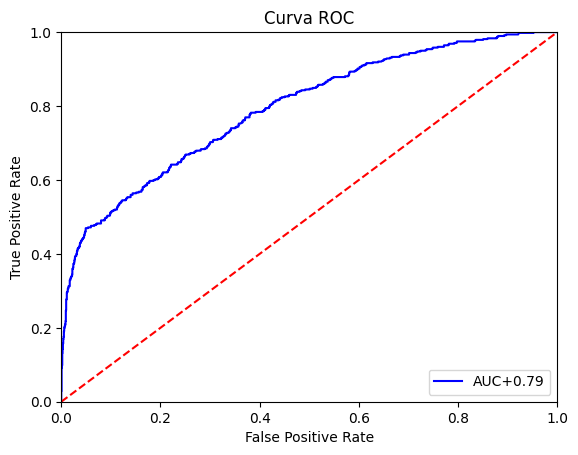

In [72]:
predicciones = modelo_ran_tuned.predict_proba(X_test)
pred = predicciones[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Curva ROC')
plt.plot(fpr, tpr, 'b', label= 'AUC+%0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

El modelo reconoce mejor ahora la clase positiva, pero se sacrifico o disminuyo la precision en cuanto a la clase negativa. Se aumenta el valor del f1 score, lo que quiere decir que las precisiones de clase estan mas balanceadas y en general el modelo predice muy bien, pero existe margen de mejora.